# Covid-19: From model prediction to model predictive control

## A tryout notebook for the MPC algorithm

*Code by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens and prof. Jan baetens of the KERMIT research unit.*

Copyright (c) 2021 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.models import models
from covid19model.data import mobility, sciensano, model_parameters

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
###############
## Load data ##
###############

# Time-integrated contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices()
levels = initN.size
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)
# Sciensano public data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)

## 1. Setup a simple SEIQRD model

In [5]:
from covid19model.models.base import BaseModel

class deterministic_SEIRD(BaseModel):

    # state variables and parameters
    state_names = ['S', 'E', 'I', 'Q', 'R', 'D']
    parameter_names = ['beta', 'sigma', 'gamma', 'IFR', 'eta', 'psi']
    parameters_stratified_names = []
    stratification = ['Nc']

    @staticmethod
    def integrate(t, S, E, I, Q, R, D, beta, sigma, gamma, IFR, eta, psi, Nc):
        
        # calculate total population
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~
        T = S + E + I + Q + R 

        # Compute infection pressure (IP) of both variants
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        IP = beta*np.matmul(Nc,(I/T))

        # Compute the  rates of change in every population compartment
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        dS = - IP*S
        dE  = IP*S - (1/sigma)*E 
        dI = (1/sigma)*E - (1/gamma)*I - eta*psi
        dQ = eta*psi - (1/gamma)*Q
        dR = (1-IFR)*(1/gamma)*(I+Q)
        dD = IFR*(1/gamma)*(I+Q)

        return dS, dE, dI, dQ, dR, dD

In [6]:
############################
## Define a draw function ##
############################

def draw_fcn(param_dict,samples_dict):
    return param_dict

In [7]:
###############################################
## Define new sort of social policy function ##
###############################################

from covid19model.models.time_dependant_parameter_fncs import ramp_fun
def compliance_func(t, states, param, l, effectivity):
    
    # Convert tau and l to dates
    l_days = pd.Timedelta(l, unit='D')
    # Define start of measures
    start_measures = pd.to_datetime('2020-03-15')
    # List of transitioning dates
    change_days = [start_measures,
                   start_measures + l_days]
    # List of transitioning values
    change_values = [param,
                     ramp_fun(param, effectivity*param, t, start_measures, l),
                     param * effectivity]
    # Return appropriate policy
    try:
        return change_values[[index for index,value in enumerate(change_days) if value > t][0]]
    except:
        return change_values[-1]

In [9]:
######################
## Initialize model ##
######################

# Define parameters
warmup = 25
l = 14
effectivity = 0.14
IFR = 0.214
Nc = np.ones(1)*sum(np.mean(Nc_all['total'],axis=0))
params = {'beta': 0.023, 'sigma': 3, 'gamma': 7, 'IFR': IFR, 'eta': 0.25, 'psi': 0, 'Nc': Nc,
          'l': l, 'effectivity': effectivity}
# Define initial states
initial_states = {"S": np.ones(1)*sum(initN), "E": np.ones(1)}
# Initialize model (SDEs are discrete time models and require the discrete=True flag upon initialization)
model = deterministic_SEIRD(initial_states, params, time_dependent_parameters={'Nc': compliance_func})

In [10]:
########################
## Perform simulation ##
########################

start_sim = '2020-03-15'
end_sim = '2020-07-15'
out = model.sim(end_sim,start_date=start_sim,warmup=warmup)

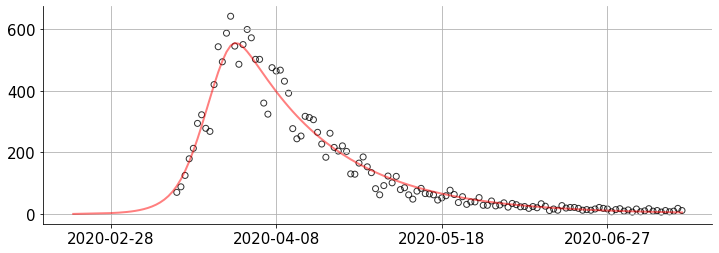

In [11]:
#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(out['time'],out['I'].sum(dim='Nc'), color='red', alpha = 0.5, linewidth = 2)
ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.show()
plt.close()

## 2. Test some of the individual functions

In [32]:
from covid19model.models.MPC import MPC

In [33]:
values_Nc = list(np.linspace(Nc*effectivity,Nc,4))

control_handles_dict = {'Nc': {
                                'continuous' : False,
                                'bounds_values' : values_Nc,
                                'costs' : list(np.linspace(10e6, 0,4)),
                                }
                       }

In [34]:
controller = MPC(model, control_handles_dict)

In [35]:
values = [values_Nc[1],
          values_Nc[0],
          values_Nc[0],
          values_Nc[1],
          values_Nc[0],
          values_Nc[0],
          values_Nc[1]]
L = 14

### Tryout  `construct_horizon` TDPF

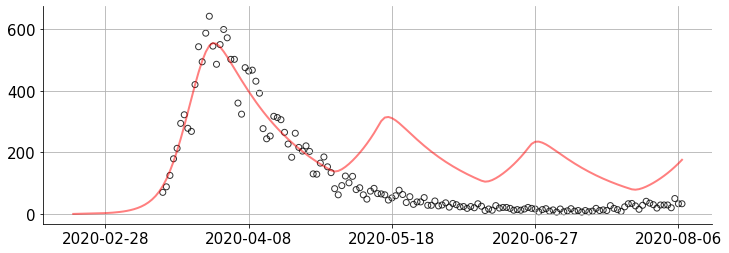

In [36]:
###############################
## Construct policy function ##
###############################

tryout_function = controller.construct_horizon(values, L, 'Nc', pd.to_datetime('2020-05-01'))
t = pd.Timestamp('2020-03-30')

############################
## Change policy function ##
############################

model.time_dependent_parameters.update({'Nc': tryout_function})

########################
## Perform simulation ##
########################

start_sim = '2020-03-15'
start_controller = '2020-05-01'
end_sim = pd.to_datetime(start_controller) + pd.Timedelta(days=len(values)*L)
out = model.sim(end_sim,start_date=start_sim,warmup=warmup)

#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['I'].sum(dim='Nc'), color='red', alpha = 0.5, linewidth = 2)
ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.show()
plt.close()

### Tryout `cost_economic`

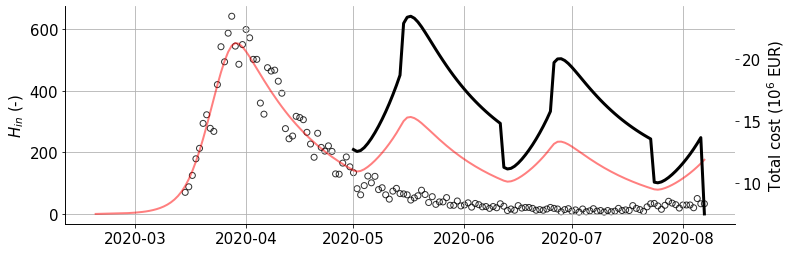

In [39]:
cost_lst = controller.cost_economic(out, {'Nc': values}, pd.to_datetime(start_controller), L, {'I': 8*25000*IFR} )/1e6

#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['I'].sum(dim='Nc'), color='red', alpha = 0.5, linewidth = 2)
ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.set_ylabel('$H_{in}$ (-)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

ax2=ax.twinx()
ax2.plot(pd.date_range(start=start_controller, periods=len(cost_lst)), cost_lst, color='black')    
ax2.grid(False)
ax2.set_ylabel('Total cost ($10^6$ EUR)')
plt.show()
plt.close()

### Tryout `cost_setpoint`

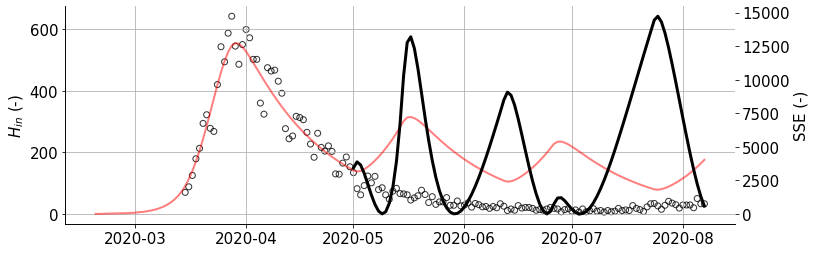

In [14]:
cost_lst = controller.cost_setpoint(out, {}, pd.to_datetime(start_controller), ['I'], [200], [1] )

#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['I'].sum(dim='Nc'), color='red', alpha = 0.5, linewidth = 2)
ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.set_ylabel('$H_{in}$ (-)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

ax2=ax.twinx()
ax2.plot(pd.date_range(start=start_controller, periods=len(cost_lst)), cost_lst, color='black')    
ax2.grid(False)
ax2.set_ylabel('SSE (-)')
plt.show()
plt.close()

## 3. Test with one discrete control handle, `Nc` and setpoint cost function

In [15]:
L = 14
N = 5
P = 6
t_start_controller = pd.Timestamp('2020-05-01')
t_start_simulation = pd.Timestamp('2020-03-15')
cost_function = controller.cost_setpoint
cost_function_args = [['I'], [200], [1]]
maxiter = 20
popsize = 20
simulation_kwargs={'warmup': warmup}
estimate, TDPFs = controller.pso_optimize(L, N, P, t_start_controller, t_start_simulation, cost_function, maxiter, popsize, *cost_function_args, **simulation_kwargs)

No constraints given.
New best for swarm at iteration 1: [0.         0.         1.6071457  1.75982903 0.6704048 ] 884009.7504456487
Best after iteration 1: [0.         0.         1.6071457  1.75982903 0.6704048 ] 884009.7504456487
Best after iteration 2: [0.         0.         1.6071457  1.75982903 0.6704048 ] 884009.7504456487
Best after iteration 3: [0.         0.         1.6071457  1.75982903 0.6704048 ] 884009.7504456487
Best after iteration 4: [0.         0.         1.6071457  1.75982903 0.6704048 ] 884009.7504456487
Best after iteration 5: [0.         0.         1.6071457  1.75982903 0.6704048 ] 884009.7504456487
Best after iteration 6: [0.         0.         1.6071457  1.75982903 0.6704048 ] 884009.7504456487
Best after iteration 7: [0.         0.         1.6071457  1.75982903 0.6704048 ] 884009.7504456487
Best after iteration 8: [0.         0.         1.6071457  1.75982903 0.6704048 ] 884009.7504456487
Best after iteration 9: [0.         0.         1.6071457  1.75982903 0.67040

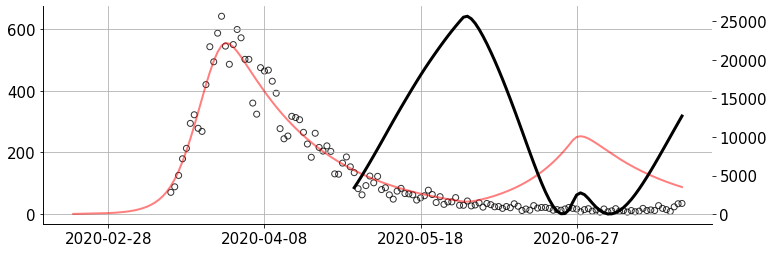

In [16]:
#########################
## Set estimated TDPFs ##
#########################

for ch,TDPF in TDPFs.items():
    model.time_dependent_parameters.update({ch: TDPF})
    
########################
## Perform simulation ##
########################

start_sim = '2020-03-15'
start_controller = '2020-05-01'
end_sim = pd.to_datetime(start_controller) + pd.Timedelta(days=P*L)
out = model.sim(end_sim,start_date=start_sim,warmup=warmup)

###########################
## Compute cost function ##
###########################

cost_lst = controller.cost_setpoint(out, {}, t_start_controller, *cost_function_args)

#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['I'].sum(dim='Nc'), color='red', alpha = 0.5, linewidth = 2)
ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.set_ylabel('$H_{in}$ (-)')

ax2=ax.twinx()
ax2.plot(pd.date_range(start=start_controller, periods=len(cost_lst)), cost_lst, color='black')    
ax2.grid(False)
ax2.set_ylabel('SSE (-)')

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.show()
plt.close()

## 4. Test with discrete control handle, `Nc` and economic cost function

In [75]:
control_handles_dict = {'Nc': {
                                'continuous' : False,
                                'bounds_values' : values_Nc,
                                'costs' : list(np.linspace(800e6, 0,4)),
                                }
                       }
controller.control_handles_dict = control_handles_dict

In [82]:
L = 14
N = 4
P = 6
t_start_controller = pd.Timestamp('2020-05-01')
t_start_simulation = pd.Timestamp('2020-03-15')
cost_function = controller.cost_economic
cost_function_args = [L, {'I': 5*50000*IFR}]
maxiter = 2
popsize = 2
simulation_kwargs={'warmup': warmup}
thetas, thetas_values, TDPFs = controller.pso_optimize(L, N, P, t_start_controller, t_start_simulation, cost_function, maxiter, popsize, *cost_function_args, **simulation_kwargs)

No constraints given.
New best for swarm at iteration 1: [0.         0.88119427 0.         1.19763356] 41458233244.37644
Best after iteration 1: [0.         0.88119427 0.         1.19763356] 41458233244.37644
Best after iteration 2: [0.         0.88119427 0.         1.19763356] 41458233244.37644
Stopping search: maximum iterations reached --> 2


[8.07572551e+08 8.07236701e+08 8.06915346e+08 8.06609471e+08
 8.06319964e+08 8.06044002e+08 8.05779534e+08 8.05525383e+08
 8.05281033e+08 8.05046631e+08 8.04822984e+08 8.04611269e+08
 8.04409787e+08 8.04216855e+08 8.04031574e+08 8.03853493e+08
 8.03682607e+08 8.03519358e+08 8.03364576e+08 8.03217555e+08
 8.03076920e+08 8.02941910e+08 8.02812094e+08 8.02687374e+08
 8.02567983e+08 8.02454487e+08 8.02347181e+08 8.02244824e+08
 8.02146646e+08 8.02052184e+08 8.01961256e+08 8.01873963e+08
 8.01790689e+08 8.01712038e+08 8.01637441e+08 8.01566025e+08
 8.01497346e+08 8.01431187e+08 8.01367557e+08 8.01306694e+08
 8.01249060e+08 8.01194381e+08 5.34474821e+08 5.34446755e+08
 5.34463264e+08 5.34507982e+08 5.34572283e+08 5.34649584e+08
 5.34738116e+08 5.34836120e+08 5.34942670e+08 5.35058318e+08
 5.35183170e+08 5.35317018e+08 5.35460713e+08 5.35615208e+08
 2.44789672e+06 2.62596303e+06 2.81652231e+06 3.02076452e+06
 3.24010838e+06 3.47583114e+06 3.72906798e+06 4.00081203e+06
 4.29191430e+06 4.602803

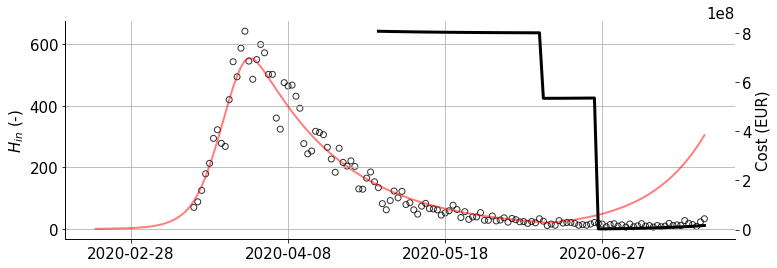

In [83]:
#########################
## Set estimated TDPFs ##
#########################

for ch,TDPF in TDPFs.items():
    model.time_dependent_parameters.update({ch: TDPF})
    
########################
## Perform simulation ##
########################

start_sim = '2020-03-15'
start_controller = '2020-05-01'
end_sim = pd.to_datetime(start_controller) + pd.Timedelta(days=P*L-1)
out = model.sim(end_sim,start_date=start_sim,warmup=warmup)

###########################
## Compute cost function ##
###########################

cost_lst = controller.cost_economic(out, thetas_values, t_start_controller, *cost_function_args)
print(cost_lst)
#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['I'].sum(dim='Nc'), color='red', alpha = 0.5, linewidth = 2)
ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.set_ylabel('$H_{in}$ (-)')

ax2=ax.twinx()
ax2.plot(pd.date_range(start=start_controller, periods=len(cost_lst)), cost_lst, color='black')    
ax2.grid(False)
ax2.set_ylabel('Cost (EUR)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.show()
plt.close()

## 5. Test with discrete control handle, `Nc` and one continuous control handle `psi`

In [31]:
control_handles_dict.update({'psi' : {
                                        'continuous' : True,
                                        'bounds_values' : (0,40),
                                        'costs' : [100],
                                        }
                            })

In [32]:
model = models.deterministic_SEIRD(initial_states, params, time_dependent_parameters={'Nc': compliance_func})
controller = MPC(model, control_handles_dict)

In [33]:
L = 14
N = 5
P = 6
t_start_controller = pd.Timestamp('2020-05-01')
t_start_simulation = pd.Timestamp('2020-03-15')
cost_function = controller.cost_setpoint
cost_function_args = [['I'],[200],[1]]
maxiter = 5
popsize = 5
simulation_kwargs={'warmup': warmup}
estimate, TDPFs = controller.pso_optimize(L, N, P, t_start_controller, t_start_simulation, cost_function, maxiter, popsize, *cost_function_args, **simulation_kwargs)

No constraints given.
Best after iteration 1: [ 0.81503603  1.2148756   0.98490323  0.49207633  0.56308489  6.07657573
  1.2191221   2.10739973 34.28908723 25.46492321] 2898063.0198796703
Best after iteration 2: [ 0.81503603  1.2148756   0.98490323  0.49207633  0.56308489  6.07657573
  1.2191221   2.10739973 34.28908723 25.46492321] 2898063.0198796703
New best for swarm at iteration 3: [ 0.82525147  0.0607729   3.64781381  0.          1.98771884 15.99031514
  4.1895952   1.06947661 31.62441874 32.11916093] 1090118.92924206
Best after iteration 3: [ 0.82525147  0.0607729   3.64781381  0.          1.98771884 15.99031514
  4.1895952   1.06947661 31.62441874 32.11916093] 1090118.92924206
Best after iteration 4: [ 0.82525147  0.0607729   3.64781381  0.          1.98771884 15.99031514
  4.1895952   1.06947661 31.62441874 32.11916093] 1090118.92924206
Best after iteration 5: [ 0.82525147  0.0607729   3.64781381  0.          1.98771884 15.99031514
  4.1895952   1.06947661 31.62441874 32.119160

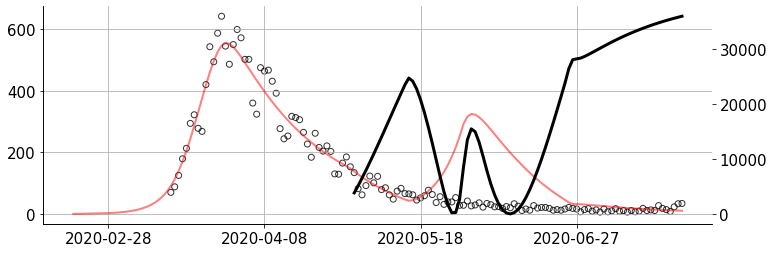

In [24]:
#########################
## Set estimated TDPFs ##
#########################

for ch,TDPF in TDPFs.items():
    model.time_dependent_parameters.update({ch: TDPF})
    
########################
## Perform simulation ##
########################

start_sim = '2020-03-15'
start_controller = '2020-05-01'
end_sim = pd.to_datetime(start_controller) + pd.Timedelta(days=P*L)
out = model.sim(end_sim,start_date=start_sim,warmup=warmup)

###########################
## Compute cost function ##
###########################

cost_lst = controller.cost_setpoint(out, {}, t_start_controller, *cost_function_args)

#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['I'].sum(dim='Nc'), color='red', alpha = 0.5, linewidth = 2)
ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')

ax2=ax.twinx()
ax2.plot(pd.date_range(start=start_controller, periods=len(cost_lst)), cost_lst, color='black')    
ax2.grid(False)

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.show()
plt.close()